# Homework 5

Ben Smith

ECON 213R

11/23/18

We will test several models to try to recognize numbers in the MNIST data set. Along the way, I answer questions given in the homework assignment.

First, import modules and the data.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage

%matplotlib inline

In [5]:
from sklearn.datasets import fetch_mldata

In [6]:
mnist = fetch_mldata("MNIST original")
X = mnist.data / 255.0
Y = mnist.target

#### 1. Use PCA to reduce the data's dimensionality.

First, let's see how many components we should have. We will choose the lowest number that explains at least 95% of the data's variance. We first visualize the amount of variance explained from 1 component to 700 components.

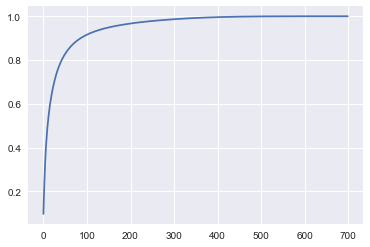

In [139]:
pca = PCA(n_components=700)
X_pca = pca.fit_transform(X)
cum_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(len(cum_ratio)), cum_ratio)

Now, calculate the right number of components. From the above graph, it looks like it'll be somewhere between 100 and 200.

In [140]:
index_95 = np.argmax(cum_ratio >= 0.95)
print(index_95)
print(cum_ratio[index_95])

153
0.950349970208


Thus, we choose 154 components (since the given result, 153, starts from 0), since it explains approximately 95% of our data.

#### 1. a. How many components did you use? Why?

#### Answer: 

#### I use 154 components, since that number is the lowest necessary to explain 95% of the data's variance.

Now, we will plot the first two components.

In [8]:
#Find the first 2 components.
pca = PCA(n_components=2)
X_2dim = pca.fit_transform(X)

c1 = X_2dim[:,0]
c2 = X_2dim[:,1]

c12 = np.array([c1,c2])
c12

array([[ 3.96272614,  4.0531941 ,  2.41341814, ..., -0.52665285,
         0.05182923,  1.33744645],
       [-1.13719801, -1.37728189, -0.95758053, ...,  2.97816285,
         3.41326813,  3.76202575]])

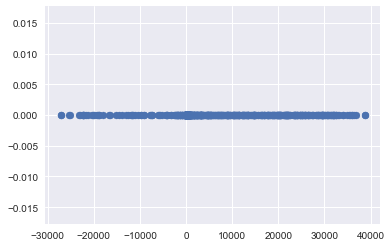

In [142]:
#Plot component 1.
proj_1 = c1.dot(X)
plt.scatter(proj_1, np.zeros(len(proj_1)))

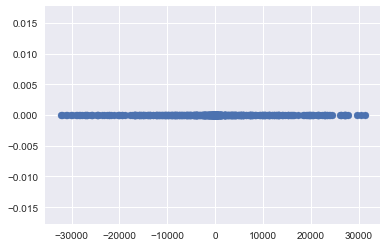

In [143]:
#Plot component 2.
proj_2 = c2.dot(X)
plt.scatter(proj_2, np.zeros(len(proj_2)))

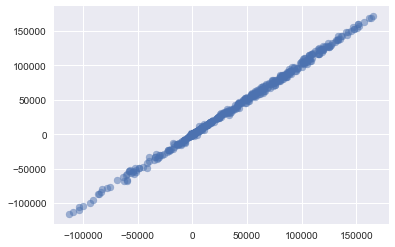

In [144]:
#Now plot the first two components together.
proj_1_2 = X.T.dot(c12.T)
reconstruct = proj_1_2.dot(c12)
plt.scatter(reconstruct[:,0], reconstruct[:,1], alpha=0.5)

#### 1. b. Plot the first two components. Do you notice any trends? What is this plot showing us?

#### Answer: 

#### Observing the first two plots, both components' plots appear to be pretty similar in width, although the width of the plot for component 2 is somewhat smaller than the width of component 1's plot . One other interesting difference is that on the first plot, values appear more concentrated to the right, while on the second plot, values are concentrated to the left and even extend farther to the left than the values on plot 1. On the third plot, we find an extremely strong positive relationship between the variance explained by the two components. Also notice that the axes on the third plot are much wider than the horizontal axes on the first two plots.

#### This last plot shows us the amount of variation in the data that can be explained using the first two components.

#### 1. c. Why would you use PCA? What is it doing? And what are the drawbacks?

#### Answer:

#### I would use PCA since it is useful in indicating how I can represent my data using fewer dimensions. This is especially useful if I want to visualize my data on a two- or three-dimensional graph. PCA finds the component that explains the most variance, then finds that component's orthogonal vectors that explain the most variance. By finding these vectors, PCA discovers what information is most important for prediction and what information is relatively unimportant. Some drawbacks to PCA are: it can be hard to interpret the components that PCA finds, and in general, PCA is not particularly useful for purposes besides visualization -- even for visualization, models such as T-SNE are often seen as more useful.

Now, let's look at some of the images and what they look like when compressed by PCA.

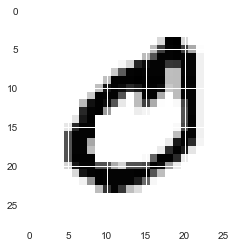

In [145]:
#Here's a zero.
plt.imshow(X[1].reshape((28,28)), cmap='Greys')

In [146]:
#Now compress that zero using the first 154 components.

pca = PCA(n_components=154)
X_comp = pca.fit_transform(X)
print(X_comp.shape)
print(X.shape)

(70000, 154)
(70000, 784)


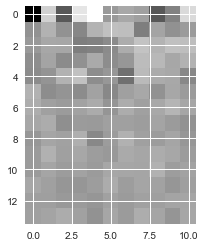

In [147]:
#Plot it!
plt.imshow(X_comp[1].reshape((14,11)), cmap='Greys')

That's actually pretty terrible.

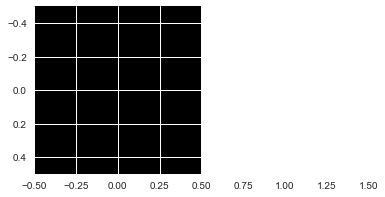

In [148]:
#Now plot that zero using only the first 2 components.
plt.imshow(X_2dim[1].reshape((1,2)), cmap='Greys')

Clearly, at least 154 components is better than 2 components.

What if we use 784 components?

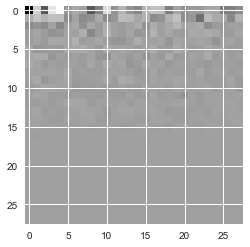

In [149]:
pca = PCA(n_components=784)
X_comp = pca.fit_transform(X)
plt.imshow(X_comp[1].reshape((28,28)), cmap='Greys')

We still don't have anything resembling a zero....

Now let's try a 5.

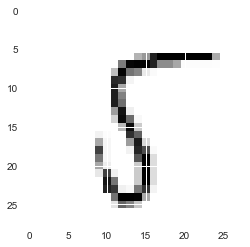

In [150]:
#Here's the original.
plt.imshow(X[34000].reshape((28,28)), cmap='Greys')

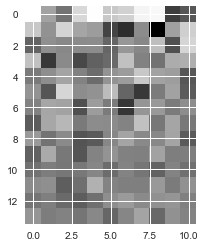

In [151]:
#Here's our PCA approximation of the 5 with 154 components.
pca = PCA(n_components=154)
X_comp = pca.fit_transform(X)
plt.imshow(X_comp[34000].reshape((14,11)), cmap='Greys')

Maybe this is better than our approximation of the 0, but it's still not great.

Finally, let's try a 9.

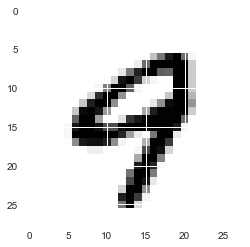

In [152]:
#Here's the original.
plt.imshow(X[69999].reshape((28,28)), cmap='Greys')

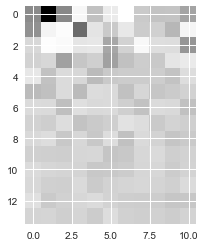

In [153]:
#Approximate 9 with 154 components.
pca = PCA(n_components=154)
X_comp = pca.fit_transform(X)
plt.imshow(X_comp[69999].reshape((14,11)), cmap='Greys')

I can kind of see a 9 in the middle! Maybe, maybe not. As with the other numbers, this approximation did a pretty bad job of recreating the 9.

#### 1. d. Plot some of the images, then compress them using PCA and plot again. How does it look?

#### Answer:

#### In every one of the above three cases, the compressed images don't resemble their original versions at all.

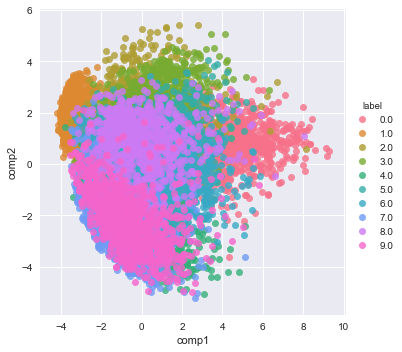

In [154]:
#Also, here's how well our PCA model with 2 components does at grouping together different numbers.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

pca_results = pca.fit_transform(X_pca[rows[:n_select],:])
df_pca = pd.DataFrame(pca_results, columns=['comp1', 'comp2'])
df_pca['label'] = Y[rows[:n_select]]

#Plot
sns.lmplot(x='comp1', y='comp2', data=df_pca, hue='label', fit_reg=False)

This grouping actually isn't so bad, alothough there are a lot of close observations that are in fact different numbers.

#### 2. Use t-SNE to plot the first two components

In [16]:
#This code will set up our t-SNE model
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 10000 #Randomly select 10,000 points

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200)
tsne_results1 = tsne.fit_transform(X_pca[rows[:n_select],:])

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.163388
[t-SNE] KL divergence after 50 iterations with early exaggeration: 1.183226
[t-SNE] Error after 225 iterations: 1.183226


In [156]:
#Prepare data and labels
df_tsne = pd.DataFrame(tsne_results1, columns=['comp1', 'comp2'])
df_tsne['label'] = Y[rows[:n_select]]

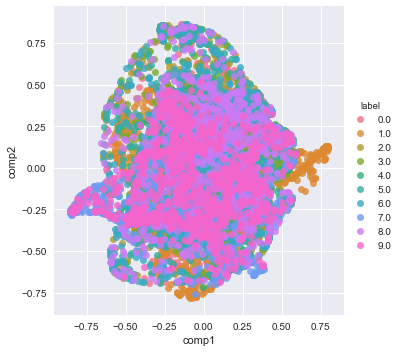

In [157]:
#Plot how our model grouped numbers together.
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)

It looks like our t-SNE model actually didn't do very well at grouping together the numbers. As with the PCA plot, 4,8, and 9 seem to be especially jumbled together.

#### 2. a. How does this plot differ from your PCA plot?

#### Answer:

#### The PCA plot that was produced with seaborn appears to have denser, better defined groups than this one. Although 1's are isolated in certain parts of this plot, the other numbers (and even 1, as well) are more scattered on this plot. Thus, although the 2 first components are shown by the plots above my answer to (1. b.) to explain a lot of variance in the data, this plot shows that they still don't place numbers into particularly distinct groups.

Let's see what happens when we change our perplexity value.

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.113990
[t-SNE] KL divergence after 50 iterations with early exaggeration: 1.678164
[t-SNE] Error after 250 iterations: 1.678164


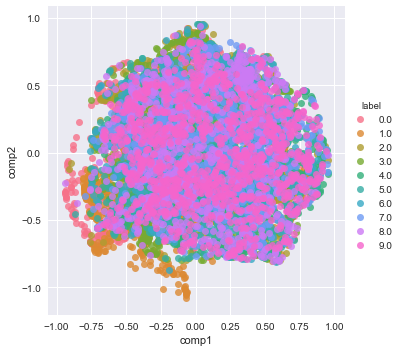

In [158]:
#Make perplexity = 25

tsne = TSNE(n_components=2, verbose=1, perplexity=25, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

#Prepare data and labels
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = Y[rows[:n_select]]

#Plot how our model grouped numbers together.
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.046550
[t-SNE] KL divergence after 50 iterations with early exaggeration: 3.024871
[t-SNE] Error after 225 iterations: 3.024871


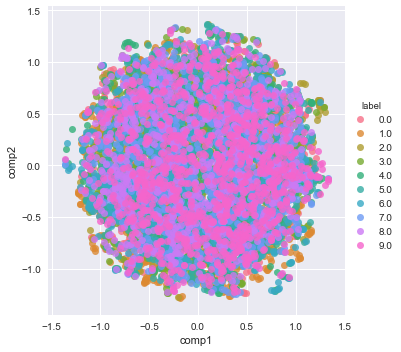

In [159]:
#Make perplexity = 5

tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

#Prepare data and labels
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = Y[rows[:n_select]]

#Plot how our model grouped numbers together.
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)

#### 2. b. How robust is it to changes in perplexity?

#### Answer:

#### It's pretty robust. Not too much seems to change as perplexity changes.

Let's see what happens when we change our learning rate and number of iterations, now using a perplexity of 25.

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.113990
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.580621
[t-SNE] Error after 325 iterations: 1.580621


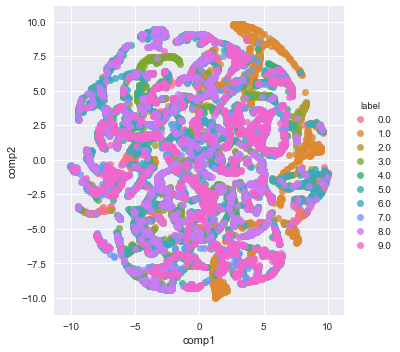

In [160]:
#Make learning rate = 1000

tsne = TSNE(n_components=2, verbose=1, perplexity=25, n_iter=1000, learning_rate=1000)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

#Prepare data and labels
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = Y[rows[:n_select]]

#Plot how our model grouped numbers together.
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.113990
[t-SNE] KL divergence after 50 iterations with early exaggeration: 1.678221
[t-SNE] Error after 75 iterations: 1.678221


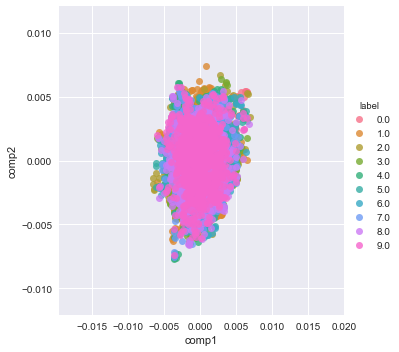

In [161]:
#Make learning rate = 100

tsne = TSNE(n_components=2, verbose=1, perplexity=25, n_iter=1000, learning_rate=100)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

#Prepare data and labels
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = Y[rows[:n_select]]

#Plot how our model grouped numbers together.
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.113990
[t-SNE] KL divergence after 50 iterations with early exaggeration: 1.678194
[t-SNE] Error after 275 iterations: 1.678194


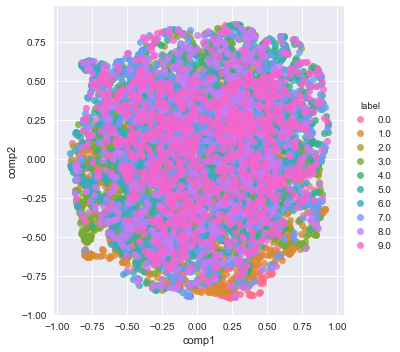

In [164]:
#Make n_iter = 2000

tsne = TSNE(n_components=2, verbose=1, perplexity=25, n_iter=2000, learning_rate=200)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

#Prepare data and labels
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = Y[rows[:n_select]]

#Plot how our model grouped numbers together.
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.113990
[t-SNE] KL divergence after 50 iterations with early exaggeration: 1.678187
[t-SNE] Error after 200 iterations: 1.678187


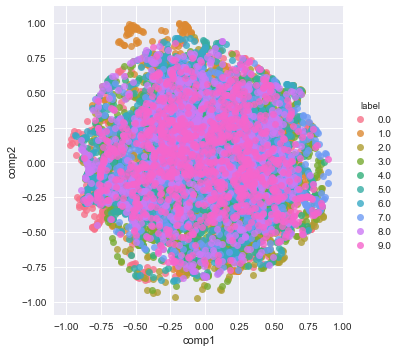

In [165]:
#Make n_iter = 200

tsne = TSNE(n_components=2, verbose=1, perplexity=25, n_iter=200, learning_rate=200)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

#Prepare data and labels
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = Y[rows[:n_select]]

#Plot how our model grouped numbers together.
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)

#### 2. c. How robust is it to different learning rate and number of iterations?

#### Answer:

#### It's very robust to the number of iterations. These plots hardly change as the number of iterations changes. It is not very robust with respect to learning rate, however. Notice that with every change in the learning rate, the resulting plot changes substantially.

#### 3. Perform k-means clustering

Let's see what we should set k as.

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


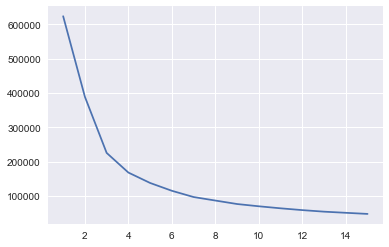

In [176]:
#We use the reduced-dimensionality version of the data with only two components.
sses = []
for k in range(1,16):
    print(k)
    kmeans = KMeans(n_clusters=k, n_init=50, n_jobs=-1)
    kmeans.fit(X_2dim)
    sses.append(kmeans.inertia_)
#Plot the usefulness of each additional marginal cluster, as measured by sum of squared distances.
plt.plot(range(1,16), sses)

Notice that the above plot really levels off beyond about 10 clusters. Let's pick k=10. One other reason to pick 10: there are 10 numbers in the dataset.

In [14]:
#Now plot the groups given by k-means, using the best number of clusters.
kmeans = KMeans(n_clusters = 10, n_init=50, n_jobs=-1)
kmeans.fit(X_2dim)
sk_clusters = kmeans.predict(X_2dim) 

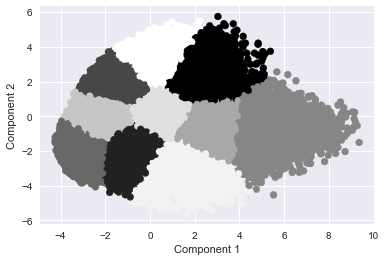

In [184]:
comp1 = X_2dim[:,0]
comp2 = X_2dim[:,1]

plt.scatter(comp1, comp2, c=sk_clusters)
plt.xlabel("Component 1")
plt.ylabel("Component 2")

These groups look very nicely divided up.

#### 3. a. How did you choose k?

#### Answer:

#### I chose k = 10 since beyond 10 clusters, each additional cluster reduces the sum of squared distances by relatively little. Furthermore, there are exactly 10 numbers in the data.

Evaluate the K-means clustering method using a Silhouette score.

In [12]:
n_select = 10000
kmeans_model = KMeans(n_clusters=10, n_init=50, n_jobs=-1).fit(X_2dim[rows[:n_select],:])
#Get labels
labels = kmeans_model.labels_

#Get Silhouette score
silhouette_score(X_2dim[rows[:n_select],:], labels, metric='euclidean')

0.35108433786677368

#### 3. b. How did you evaluate your clustering?

#### Answer:

#### I evaluated my clustering with the Silhouette score. I got a score of about 0.35 on a scale from -1 to 1.

Now, let's visualize our clusters using t-SNE.

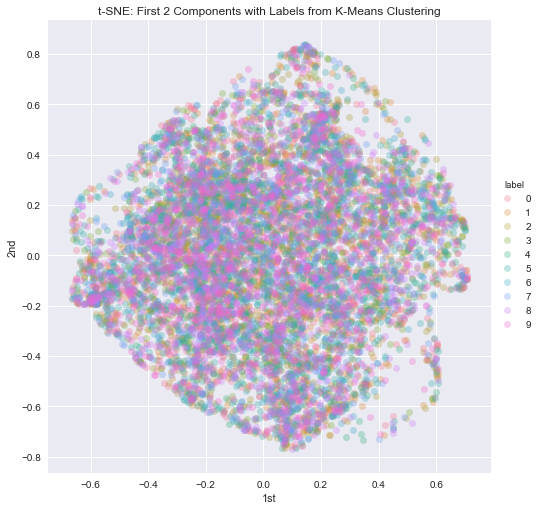

In [18]:
#Create dataframe with results 
df_tsne = pd.DataFrame(tsne_results1, columns=['1st','2nd'])
df_tsne['label'] = labels

#Plot our data!
sns.lmplot(x='1st', y='2nd', data=df_tsne, hue = 'label', fit_reg=False, scatter_kws={'alpha':0.3},size=7)
plt.title('t-SNE: First 2 Components with Labels from K-Means Clustering')


There we go! Clearly, our data isn't grouped particularly well, but we can expect that when we're only using two components.

#### 3. c. Visualize your clusters using t-sne -- Done!!

Let's try scaling our data and see what happens with K-means clustering then.

In [19]:
#scale data
scaler = StandardScaler()
scaler.fit(X_2dim)
s_data = scaler.fit_transform(X_2dim)

7
8
9
10
11
12
13


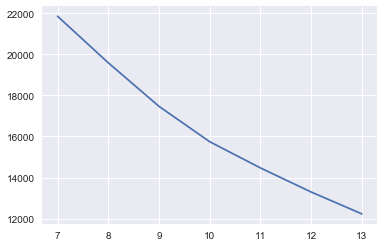

In [20]:
#Find the best values for k.
sses = []
for k in range(7,14):
    print(k)
    kmeans = KMeans(n_clusters=k, n_init=50, n_jobs=-1)
    kmeans.fit(s_data)
    sses.append(kmeans.inertia_)
#Plot the usefulness of each additional marginal cluster, as measured by sum of squared distances.
plt.plot(range(7,14), sses)

Notice that there is now a visible elbow at about k = 10. Thus, 10 is again a good choice for k.

In [21]:
#Now plot the groups given by k-means, using the best number of clusters.
kmeans = KMeans(n_clusters = 10, n_init=50, n_jobs=-1)
kmeans.fit(s_data)
sk_clusters = kmeans.predict(s_data) 

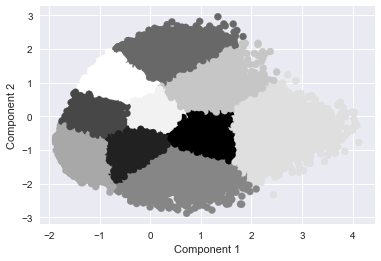

In [22]:
comp1 = s_data[:,0]
comp2 = s_data[:,1]

plt.scatter(comp1, comp2, c=sk_clusters)
plt.xlabel("Component 1")
plt.ylabel("Component 2")

In [23]:
#Evaluate the K-means clustering method using a Silhouette score.

n_select = 10000
kmeans_model = KMeans(n_clusters=10, n_init=50, n_jobs=-1).fit(s_data[rows[:n_select],:])
#Get labels
labels = kmeans_model.labels_

#Get Silhouette score
silhouette_score(s_data[rows[:n_select],:], labels, metric='euclidean')

0.35737547651418727

This silhouette score is a little higher than when our data was unscaled, but not too different.

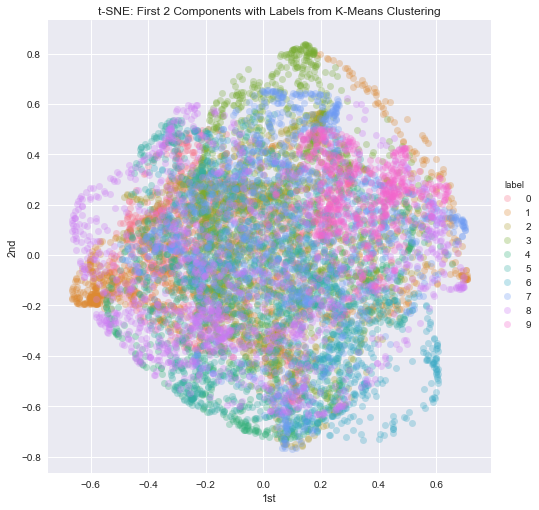

In [24]:
#Now, let's visualize our clusters using t-SNE.

#Create dataframe with results 
df_tsne = pd.DataFrame(tsne_results1, columns=['1st','2nd'])
df_tsne['label'] = labels

#Plot our data!
sns.lmplot(x='1st', y='2nd', data=df_tsne, hue = 'label', fit_reg=False, scatter_kws={'alpha':0.3},size=7)
plt.title('t-SNE: First 2 Components with Labels from K-Means Clustering')

This plot is still pretty blurry, but it seems somewhat better than the unscaled plot.

#### 3. d. Did you scale your data?

#### Answer:

#### Yes! I found that the Silhouette score is a little better when I scale it, but not much really changes.

Let's check the robustness of our clustering. We will see what changes when k, n_init and n_jobs change.

0.37732712355851072

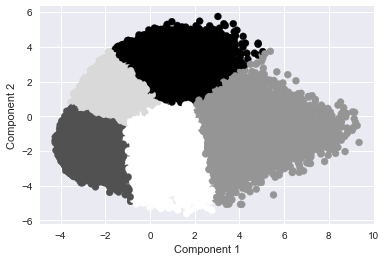

In [25]:
#k=5
#Plot the groups given by k-means, using the best number of clusters.
kmeans = KMeans(n_clusters = 5, n_init=50, n_jobs=-1)
kmeans.fit(X_2dim)
sk_clusters = kmeans.predict(X_2dim) 
comp1 = X_2dim[:,0]
comp2 = X_2dim[:,1]

plt.scatter(comp1, comp2, c=sk_clusters)
plt.xlabel("Component 1")
plt.ylabel("Component 2")

#Calculate silhouette score.

kmeans_model = KMeans(n_clusters=5, n_init=50, n_jobs=-1).fit(X_2dim[rows[:n_select],:])
#Get labels
labels = kmeans_model.labels_

#Get Silhouette score
silhouette_score(X_2dim[rows[:n_select],:], labels, metric='euclidean')

0.34773065544084475

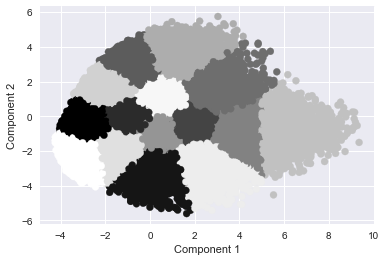

In [26]:
#k=15

#Plot the groups given by k-means, using the best number of clusters.
kmeans = KMeans(n_clusters = 15, n_init=50, n_jobs=-1)
kmeans.fit(X_2dim)
sk_clusters = kmeans.predict(X_2dim) 
comp1 = X_2dim[:,0]
comp2 = X_2dim[:,1]

plt.scatter(comp1, comp2, c=sk_clusters)
plt.xlabel("Component 1")
plt.ylabel("Component 2")

#Calculate silhouette score.

kmeans_model = KMeans(n_clusters=15, n_init=50, n_jobs=-1).fit(X_2dim[rows[:n_select],:])
#Get labels
labels = kmeans_model.labels_

#Get Silhouette score
silhouette_score(X_2dim[rows[:n_select],:], labels, metric='euclidean')

0.3579707285621101

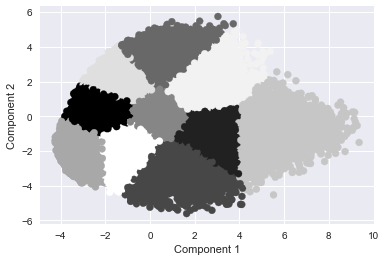

In [27]:
#n_init = 5

#Plot the groups given by k-means, using the best number of clusters.
kmeans = KMeans(n_clusters = 10, n_init=5, n_jobs=-1)
kmeans.fit(X_2dim)
sk_clusters = kmeans.predict(X_2dim) 
comp1 = X_2dim[:,0]
comp2 = X_2dim[:,1]

plt.scatter(comp1, comp2, c=sk_clusters)
plt.xlabel("Component 1")
plt.ylabel("Component 2")

#Calculate silhouette score.

kmeans_model = KMeans(n_clusters=10, n_init=5, n_jobs=-1).fit(X_2dim[rows[:n_select],:])
#Get labels
labels = kmeans_model.labels_

#Get Silhouette score
silhouette_score(X_2dim[rows[:n_select],:], labels, metric='euclidean')

0.3580606795488942

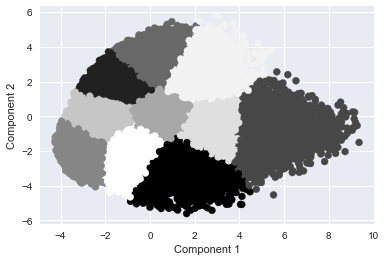

In [28]:
#n_init = 25

#Plot the groups given by k-means, using the best number of clusters.
kmeans = KMeans(n_clusters = 10, n_init=25, n_jobs=-1)
kmeans.fit(X_2dim)
sk_clusters = kmeans.predict(X_2dim) 
comp1 = X_2dim[:,0]
comp2 = X_2dim[:,1]

plt.scatter(comp1, comp2, c=sk_clusters)
plt.xlabel("Component 1")
plt.ylabel("Component 2")

#Calculate silhouette score.

kmeans_model = KMeans(n_clusters=10, n_init=25, n_jobs=-1).fit(X_2dim[rows[:n_select],:])
#Get labels
labels = kmeans_model.labels_

#Get Silhouette score
silhouette_score(X_2dim[rows[:n_select],:], labels, metric='euclidean')

0.35808212237816894

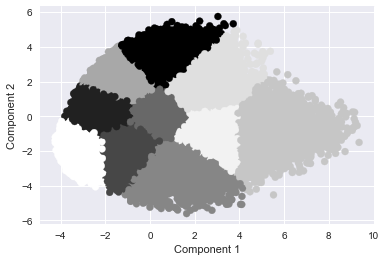

In [29]:
#n_jobs = None

#Plot the groups given by k-means, using the best number of clusters.
kmeans = KMeans(n_clusters = 10, n_init=50, n_jobs=None)
kmeans.fit(X_2dim)
sk_clusters = kmeans.predict(X_2dim) 
comp1 = X_2dim[:,0]
comp2 = X_2dim[:,1]

plt.scatter(comp1, comp2, c=sk_clusters)
plt.xlabel("Component 1")
plt.ylabel("Component 2")

#Calculate silhouette score.

kmeans_model = KMeans(n_clusters=10, n_init=50, n_jobs=None).fit(X_2dim[rows[:n_select],:])
#Get labels
labels = kmeans_model.labels_

#Get Silhouette score
silhouette_score(X_2dim[rows[:n_select],:], labels, metric='euclidean')

0.35805025655239064

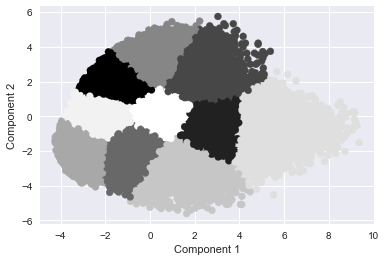

In [30]:
#n_jobs = 2

#Plot the groups given by k-means, using the best number of clusters.
kmeans = KMeans(n_clusters = 10, n_init=50, n_jobs=2)
kmeans.fit(X_2dim)
sk_clusters = kmeans.predict(X_2dim) 
comp1 = X_2dim[:,0]
comp2 = X_2dim[:,1]

plt.scatter(comp1, comp2, c=sk_clusters)
plt.xlabel("Component 1")
plt.ylabel("Component 2")

#Calculate silhouette score.

kmeans_model = KMeans(n_clusters=10, n_init=50, n_jobs=2).fit(X_2dim[rows[:n_select],:])
#Get labels
labels = kmeans_model.labels_

#Get Silhouette score
silhouette_score(X_2dim[rows[:n_select],:], labels, metric='euclidean')

#### 3. e. How robust is your clustering?

#### Answer:

#### My clustering is pretty robust. I get similar silhouette scores and cluster divisions for all values of n_clusters, n_init, and n_jobs. The largest difference in silhouette scores comes through changes in n_clusters.

#### 4. Perform hierarchical clustering 

First, let's split our data up into a random sample of 100 observations, so that we have space to plot a dendrogram.

In [201]:
#The way I split the data was inspired by Daniel at https://stackoverflow.com/questions/14262654/numpy-get-random-set-of-rows-from-2d-array
rand_index = np.random.randint(70000, size=100) 
X_rand = X[rand_index,:]
#X_rand = X_2dim[rand_index,:]

Now let's produce our dendrogram for our random sample!

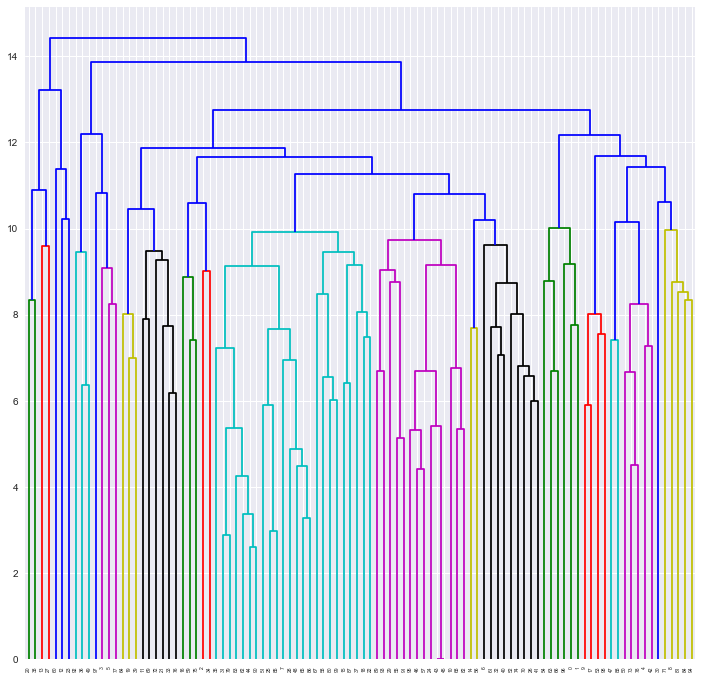

In [202]:
Z = linkage(X_rand, 'complete')
plt.figure(figsize=(12, 12))
_ = dendrogram(Z)

There it is! This is our dendogram on a random sample of our data.

#### 4. a. Plot your dendrogram -- Done!

What would happen if we use our reduced-dimension data with only two components?

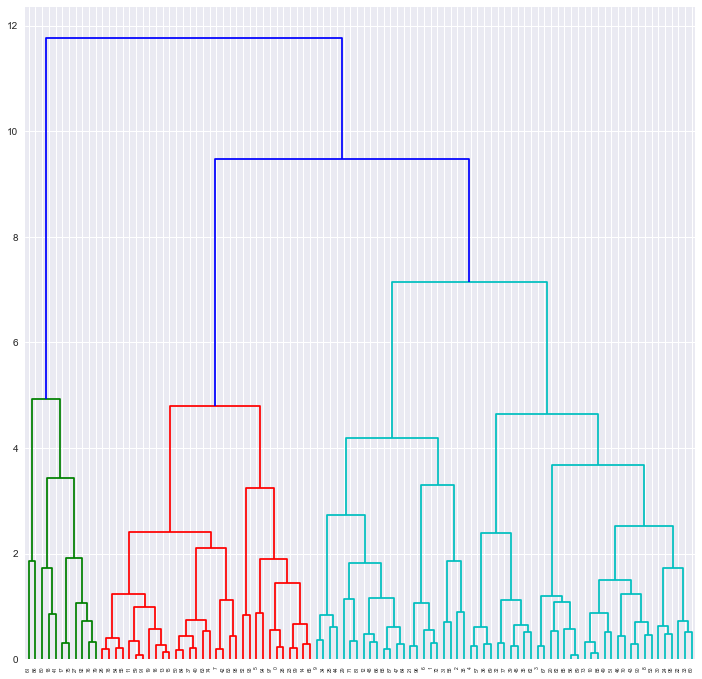

In [203]:
rand_index = np.random.randint(70000, size=100) 
X_2rand = X_2dim[rand_index,:]

Z = linkage(X_2rand, 'complete')
plt.figure(figsize=(12, 12))
_ = dendrogram(Z)

#### 4. b. How many clusters seem reasonable based off your graph?

#### Answer:

#### The first dendrogram divides the data into 21 different main clusters, while the second divides the data into 3 main clusters. If I had no prior knowledge, I would thus say that 21 clusters would be most reasonable for our main dataset and 3 would be ideal for our 2-dimensional dataset. However, as discussed before, it's worth remembering that there are exactly 10 different kinds of numbers, so 10 would ideally be the best number of clusters. Given that numbers may look similar in different ways, however, I would be more likely to trust divisions into 21 clusters than 3 clusters, since I would prefer to have multiple different clusters full of the same number (more likely with 21 clusters) than multiple numbers in the same giant cluster (inevitable with 3 clusters).

Let's try other linkage methods! We use the full dataset in this case -- both the full dataset and it's two-dimensional version should be able to showcase the differences between linkage methods pretty well.

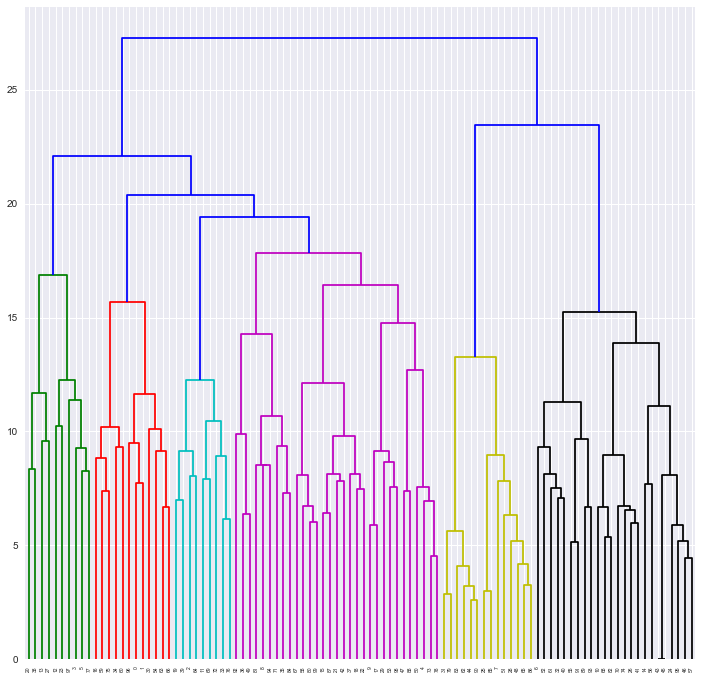

In [204]:
#Ward linkage
#rand_index = np.random.randint(70000, size=100) 
#X_rand = X[rand_index,:]

Z = linkage(X_rand, 'ward')
plt.figure(figsize=(12, 12))
_ = dendrogram(Z)

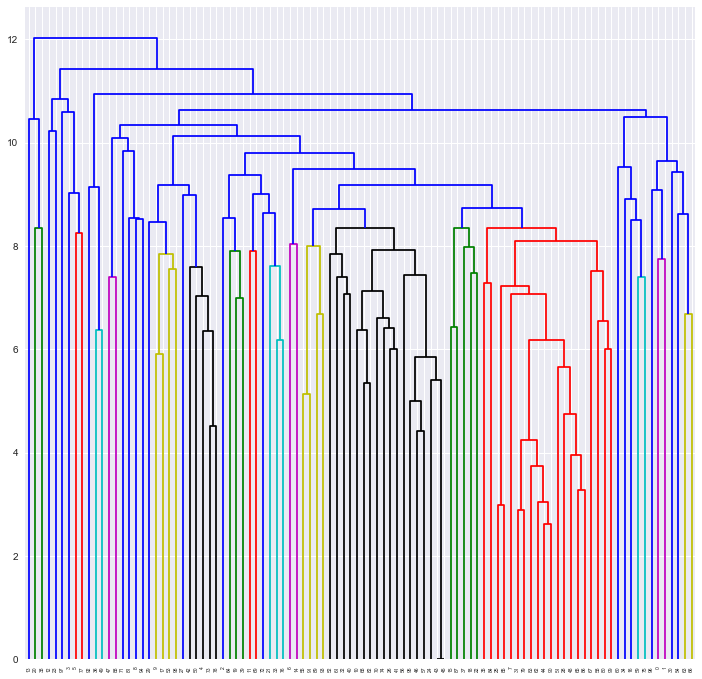

In [205]:
#Average linkage
#rand_index = np.random.randint(70000, size=100) 
#X_rand = X[rand_index,:]

Z = linkage(X_rand, 'average')
plt.figure(figsize=(12, 12))
_ = dendrogram(Z)

#### 4. c. How does your dendrogram change with different linkage methods?

#### Answer:

#### With ward linkage, distances between the least similar pairs are much larger than with the other linkage methods, and distances between divisions tend to be wider as well. Ward also divides the data into fewer main clusters. Average linkage, on the other hand, tends to pair up observations at relatively higher distances than the other methods, and then less distance is found between main clusters.

#### As a result, we can observe that ward linkage produces a dendrogram that is taller but more spread out, with much fewer main clusters, while average linkage produces a dendrogram whose pairs are split near the maximum distance.